#Dependencies

In [1]:
!pip3 install flair
!pip install contractions
!pip install beautifulsoup4
!pip install bertopic

     |████████████████████████████████| 322 kB 5.1 MB/s 
     |████████████████████████████████| 48 kB 4.7 MB/s 
     |████████████████████████████████| 64 kB 2.4 MB/s 
     |████████████████████████████████| 3.3 MB 42.4 MB/s 
     |████████████████████████████████| 981 kB 49.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 19.7 MB 8.7 MB/s 
     |████████████████████████████████| 1.2 MB 28.6 MB/s 
     |████████████████████████████████| 61 kB 425 kB/s 
     |████████████████████████████████| 788 kB 41.9 MB/s 
     |████████████████████████████████| 62 kB 690 kB/s 
     |████████████████████████████████| 895 kB 24.4 MB/s 
     |████████████████████████████████| 3.3 MB 42.9 MB/s 
     |████████████████████████████████| 596 kB 44.9 MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-py3-none-any.whl size=9704 sha256=5044b624201ca9fd028d2ee894725c1cffecbcf20e0372

#Imports


In [2]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import flair

import os
from ast import literal_eval
import bz2
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
import numpy as np

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
from nltk.stem.porter import *
stemmer = PorterStemmer()
#print(STOPWORDS)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


#Preprocess

In [3]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # print(document)
    # strip HTML
    # document = strip_html_tags(document)
    # document = re.sub(r'[hH][tT][tT][pP][Ss]?:\/\/.*[\r\n]* ?', '', document)
    st=re.search(r'\[([^]]+)\]', document)
    # print(document)
    if(st):
      st=st.group(1)
      document = document.replace(st,"")
      # print(st)
    
    document = ' '.join(word for word in document.split() )#if word.lower() not in STOPWORDS) 
    # document = st+document[]
    document = REPLACE_BY_SPACE_RE.sub(' ', document) 
    # lower case
    document = document.lower()
    # remove links
    
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    # document = remove_accented_chars(document)
    # expand contractions    
    # document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    #special_char_pattern = re.compile(r'([{.(-)!}])')
    #document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    # document= ' '.join(stemmer.stem(i) for i in document.split())
    document = document.strip()
    if(st):
      sb=st.lower().strip()
      if(len(sb)>1):
        sb+=" "
      document = sb + document
    
    # document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    # print(document)
    return document

# a=pre_process_document(appended_data.iloc[4]['quotation'])

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
data=pd.read_csv('/content/drive/MyDrive/DATA_parse/quotes_2017_parse.csv', encoding='UTF-8', compression='bz2', index_col=0, chunksize=100000)
data = next(data)
#print(len(data))
#n = len(data) // 100000
#data = data.iloc[::n]
print(len(data))
data.head()

100000


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2017-05-01-000095,[ A ] lot of the people who use The Muse sort ...,Kathryn Minshew,2017-05-01 17:00:00,1,www.salon.com,NaN,['United States of America'],['business executive'],NaN
1,2017-09-12-090806,I've had and I'm having an amazing life. So I ...,Olivia Newton-John,2017-09-12 00:00:00,14,www.femalefirst.co.uk,['Olivia Newton' 'ONJ'],"['United Kingdom', 'Australia']","['singer-songwriter', 'actor', 'singer', 'film...",NaN
2,2017-10-24-000065,[ Although ] it highlights the urgent need for...,Radha Stirling,2017-10-24 23:57:43,2,uk.news.yahoo.com,NaN,NaN,NaN,NaN
3,2017-06-08-000150,"... and if the data so warrants, act for a bro...",Viral Acharya,2017-06-08 09:51:00,2,economictimes.indiatimes.com,['Viral V. Acharya'],NaN,"['economist', 'banker']",NaN
4,2017-08-29-070805,I've had lots of support through the years and...,Tom Lord,2017-08-29 20:50:20,1,onlineathens.com,['Thomas Baxter Lord'],NaN,NaN,NaN


In [6]:
data['quotation'] = data['quotation'].apply(pre_process_document)
data.head()

,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party
0,2017-05-01-000095,alot of the people who use the muse sort of ca...,Kathryn Minshew,2017-05-01 17:00:00,1,www.salon.com,NaN,['United States of America'],['business executive'],NaN
1,2017-09-12-090806,ive had and im having an amazing life so i hav...,Olivia Newton-John,2017-09-12 00:00:00,14,www.femalefirst.co.uk,['Olivia Newton' 'ONJ'],"['United Kingdom', 'Australia']","['singer-songwriter', 'actor', 'singer', 'film...",NaN
2,2017-10-24-000065,although it highlights the urgent need for jud...,Radha Stirling,2017-10-24 23:57:43,2,uk.news.yahoo.com,NaN,NaN,NaN,NaN
3,2017-06-08-000150,and if the data so warrants act for a broader ...,Viral Acharya,2017-06-08 09:51:00,2,economictimes.indiatimes.com,['Viral V. Acharya'],NaN,"['economist', 'banker']",NaN
4,2017-08-29-070805,ive had lots of support through the years and ...,Tom Lord,2017-08-29 20:50:20,1,onlineathens.com,['Thomas Baxter Lord'],NaN,NaN,NaN


#NLTK Sentiment Analyzer

In [7]:
nltk_sentiment = SentimentIntensityAnalyzer()

def classify_sentiment_nltk(doc):
  #  print(doc)
   scores = nltk_sentiment.polarity_scores(doc)
   neg_sc=scores['neg']	
   neu_sc=scores['neu']
   pos_sc=scores['pos']
   compound_sc=scores['compound']
   sentiment=np.argmax(np.array([neg_sc,neu_sc,pos_sc,compound_sc]))
   scores['sentiment'] = sentiment
   return scores
  

applied_df = data.apply(lambda row: classify_sentiment_nltk(row.quotation), axis='columns', result_type='expand')
applied_df.head()

,neg,neu,pos,compound,sentiment
0,0.063,0.771,0.166,0.6712,1.0
1,0.131,0.746,0.123,-0.0880,1.0
2,0.000,0.758,0.242,0.8360,3.0
3,0.000,0.824,0.176,0.4588,1.0
4,0.075,0.791,0.134,0.2919,1.0


In [8]:
print(data.shape,applied_df.shape)
df = pd.concat([data, applied_df],axis='columns')
df.head()

(100000, 10) (100000, 5)


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,neg,neu,pos,compound,sentiment
0,2017-05-01-000095,alot of the people who use the muse sort of ca...,Kathryn Minshew,2017-05-01 17:00:00,1,www.salon.com,NaN,['United States of America'],['business executive'],NaN,0.063,0.771,0.166,0.6712,1.0
1,2017-09-12-090806,ive had and im having an amazing life so i hav...,Olivia Newton-John,2017-09-12 00:00:00,14,www.femalefirst.co.uk,['Olivia Newton' 'ONJ'],"['United Kingdom', 'Australia']","['singer-songwriter', 'actor', 'singer', 'film...",NaN,0.131,0.746,0.123,-0.0880,1.0
2,2017-10-24-000065,although it highlights the urgent need for jud...,Radha Stirling,2017-10-24 23:57:43,2,uk.news.yahoo.com,NaN,NaN,NaN,NaN,0.000,0.758,0.242,0.8360,3.0
3,2017-06-08-000150,and if the data so warrants act for a broader ...,Viral Acharya,2017-06-08 09:51:00,2,economictimes.indiatimes.com,['Viral V. Acharya'],NaN,"['economist', 'banker']",NaN,0.000,0.824,0.176,0.4588,1.0
4,2017-08-29-070805,ive had lots of support through the years and ...,Tom Lord,2017-08-29 20:50:20,1,onlineathens.com,['Thomas Baxter Lord'],NaN,NaN,NaN,0.075,0.791,0.134,0.2919,1.0


In [9]:
rev_label=['negative','neutral','positive','compound']
temp = df[['quotation','sentiment']]
temp['sentiment'] = temp['sentiment'].map(lambda row: rev_label[int(row)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


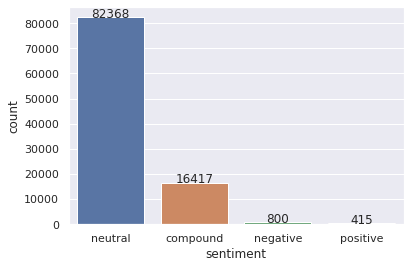

In [10]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=temp)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Neutral Words


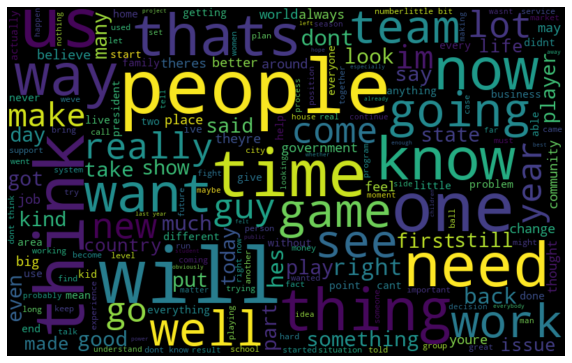

Negative Words


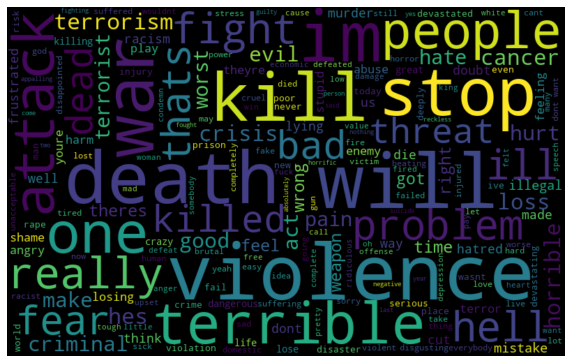

Positive Words


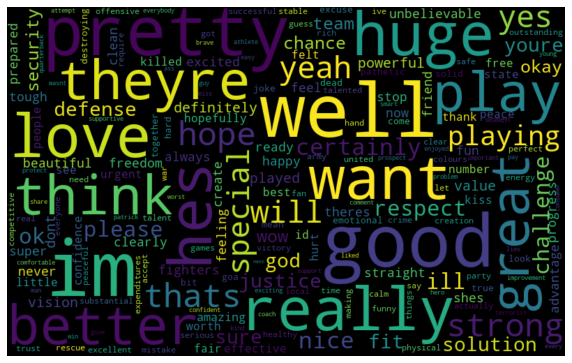

Compound Words


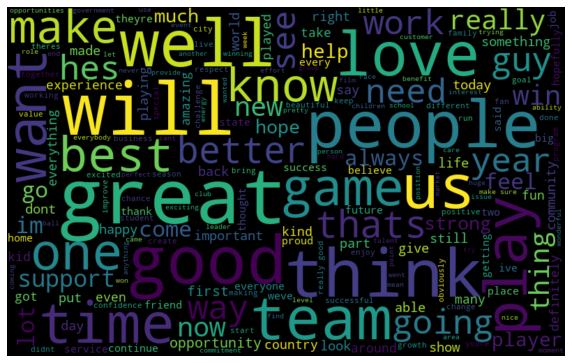

In [11]:
print("Neutral Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Positive Words")

pos_words =' '.join([text for text in df['quotation'][df['sentiment'] == 2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Compound Words")

compound_words =' '.join([text for text in df['quotation'][df['sentiment'] == 3]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(compound_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


#Flair Sentiment Analyzer

In [12]:

#flair.device = torch.device('cuda')
flair_sentiment = flair.models.TextClassifier.load('sentiment-fast')
#may need to use a faster model or batch processing 
def classify_sentiment_flair(doc):
  #  print(doc)
   s = flair.data.Sentence(doc)
   flair_sentiment.predict(s)
  #  print(s)
   #scores = [(sent.labels[0].values, sent.labels[0].score) for sent in s] 
   scores = s.labels[0]
  #  print(scores)
   return scores.value
  

applied_df_flair= data.copy()
applied_df_flair['sentiment'] = applied_df_flair['quotation'].apply(lambda quote: classify_sentiment_flair(quote))
applied_df_flair.head()

2021-12-15 17:32:21,659 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-fasttext-rnn/sentiment-en-mix-ft-rnn_v8.pt not found in cache, downloading to /tmp/tmpy_a767xw


100%|██████████| 1241977025/1241977025 [01:32<00:00, 13359157.62B/s]

2021-12-15 17:33:54,989 copying /tmp/tmpy_a767xw to cache at /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


2021-12-15 17:33:59,741 removing temp file /tmp/tmpy_a767xw
2021-12-15 17:33:59,920 loading file /root/.flair/models/sentiment-en-mix-ft-rnn_v8.pt


,quoteID,quotation,speaker,date,numOccurrences,urls_parse,aliases,nationality,occupation,party,sentiment
0,2017-05-01-000095,alot of the people who use the muse sort of ca...,Kathryn Minshew,2017-05-01 17:00:00,1,www.salon.com,NaN,['United States of America'],['business executive'],NaN,POSITIVE
1,2017-09-12-090806,ive had and im having an amazing life so i hav...,Olivia Newton-John,2017-09-12 00:00:00,14,www.femalefirst.co.uk,['Olivia Newton' 'ONJ'],"['United Kingdom', 'Australia']","['singer-songwriter', 'actor', 'singer', 'film...",NaN,POSITIVE
2,2017-10-24-000065,although it highlights the urgent need for jud...,Radha Stirling,2017-10-24 23:57:43,2,uk.news.yahoo.com,NaN,NaN,NaN,NaN,POSITIVE
3,2017-06-08-000150,and if the data so warrants act for a broader ...,Viral Acharya,2017-06-08 09:51:00,2,economictimes.indiatimes.com,['Viral V. Acharya'],NaN,"['economist', 'banker']",NaN,POSITIVE
4,2017-08-29-070805,ive had lots of support through the years and ...,Tom Lord,2017-08-29 20:50:20,1,onlineathens.com,['Thomas Baxter Lord'],NaN,NaN,NaN,POSITIVE


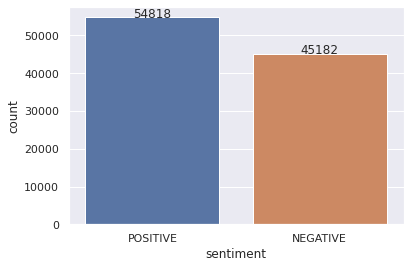

In [13]:
sns.set(style="darkgrid")
ax = sns.countplot(x='sentiment', data=applied_df_flair[['quotation','sentiment']])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

Positive Words


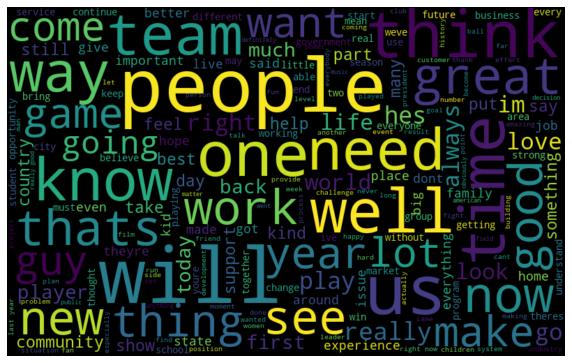

Negative Words


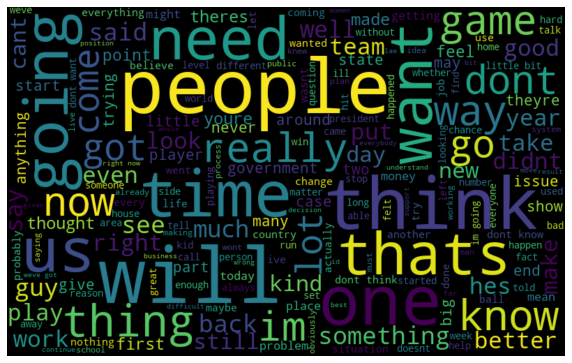

In [14]:
df=applied_df_flair.copy()
print("Positive Words")

neu_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'POSITIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neu_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Negative Words")

neg_words =' '.join([text for text in df['quotation'][df['sentiment'] == 'NEGATIVE']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# BERTtopic

In [16]:
from bertopic import BERTopic
topic_model = BERTopic(verbose=True)

In [17]:
dataset = data[['quotation', 'date']]
dataset.head()

,quotation,date
0,alot of the people who use the muse sort of ca...,2017-05-01 17:00:00
1,ive had and im having an amazing life so i hav...,2017-09-12 00:00:00
2,although it highlights the urgent need for jud...,2017-10-24 23:57:43
3,and if the data so warrants act for a broader ...,2017-06-08 09:51:00
4,ive had lots of support through the years and ...,2017-08-29 20:50:20


In [18]:
def remove_stop(document):
    document = ' '.join(word for word in document.split() if word.lower() not in STOPWORDS) 
    return document
#dataset['quotation']=dataset['quotation_x'].apply(lambda x: remove_stop(x))
dataset['quotation']=dataset['quotation'].apply(lambda x: remove_stop(x))
dataset.head()

,quotation,date
0,alot people use muse sort came age great reces...,2017-05-01 17:00:00
1,ive im amazing life complaints really dont eve...,2017-09-12 00:00:00
2,although highlights urgent need judicial refor...,2017-10-24 23:57:43
3,data warrants act broader accommodation intere...,2017-06-08 09:51:00
4,ive lots support years never imagined growing ...,2017-08-29 20:50:20


In [19]:
#sample=dataset.sample(n=100000,random_state=0)# sample size since model runs out of ram 
sample = dataset
sample.reset_index(inplace=True,drop=True)
sample.head()

,quotation,date
0,alot people use muse sort came age great reces...,2017-05-01 17:00:00
1,ive im amazing life complaints really dont eve...,2017-09-12 00:00:00
2,although highlights urgent need judicial refor...,2017-10-24 23:57:43
3,data warrants act broader accommodation intere...,2017-06-08 09:51:00
4,ive lots support years never imagined growing ...,2017-08-29 20:50:20


In [20]:
data=sample['quotation'].values.tolist()
timestamps=sample['date'].values.tolist()

In [21]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english", min_df=10)
topic_model = BERTopic(vectorizer_model=vectorizer_model,verbose=True, calculate_probabilities=False)# low_memory=True,

In [22]:
topics, probs = topic_model.fit_transform(data)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

2021-12-15 18:16:58,679 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-12-15 18:20:19,443 - BERTopic - Reduced dimensionality with UMAP
2021-12-15 18:20:37,313 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [23]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,54592,-1_game_play_team_going
1,0,918,0_students_schools_teachers_education
2,1,882,1_film_movie_movies_actor
3,2,840,2_music_song_band_rock
4,3,751,3_food_coffee_eat_eating
5,4,651,4_hes_hes really_hes good_hes got
6,5,638,5_fight_fighting_battle_belt
7,6,634,6_water_rain_weather_storm
8,7,579,7_coach_coaches_coaching_head
9,8,568,8_race_racing_races_track


In [24]:
topics_over_time = topic_model.topics_over_time(data, topics, timestamps, nr_bins=20)
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10)

20it [00:18,  1.11it/s]


In [25]:
#topics_over_time.write_html("topics_over_time_2020.html", include_plotlyjs="cdn")
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=10).write_html("topics_over_time_2017.html", include_plotlyjs="cdn")

In [26]:
fig = topic_model.visualize_topics(); fig

Output hidden; open in https://colab.research.google.com to view.

In [27]:
topic_nr = freq.iloc[0]["Topic"]  # We select a frequent topic
topic_model.get_topic(topic_nr)   # You can select a topic number as shown above

[('game', 0.001257791829813359),
 ('play', 0.0012142016689295496),
 ('team', 0.0011986068589559479),
 ('going', 0.0011658060401294088),
 ('people', 0.0011601616797388909),
 ('players', 0.0011582109694732155),
 ('lot', 0.001154542150447908),
 ('like', 0.0011539943737550282),
 ('good', 0.001151863064293064),
 ('work', 0.0011497820169580795)]

topics_over_time.write_html("topics_over_time.html", include_plotlyjs="cdn")

In [28]:
fig.write_html("Intertropic_distance_2017.html", include_plotlyjs="cdn")